In [1]:
from datetime import date
import polars as pl
import polars.selectors as cs
import xarray as xr
import numpy as np
from disfor.data_fetcher import DATA_GETTER
from nrt.monitor.ewma import EWMA
from nrt.monitor.ccdc import CCDC
from nrt.monitor.iqr import IQR
from sklearn.metrics import accuracy_score, f1_score

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/jonas/Documents/Projects/2025/DISFOR/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
labels = pl.read_parquet("/home/jonas/.cache/disfor/0.1.0/labels.parquet")
pixel_data = pl.read_parquet("/home/jonas/.cache/disfor/0.1.0/pixel_data.parquet")
labels

original_sample_id,dataset,label,original_label,start,end,sample_id,start_next_label
i64,u8,u16,str,"datetime[ms, UTC]","datetime[ms, UTC]",u16,"datetime[ms, UTC]"
0,1,110,"""0""",2016-11-10 00:00:00 UTC,2022-03-09 00:00:00 UTC,0,2022-04-08 00:00:00 UTC
0,1,212,"""6""",2022-04-08 00:00:00 UTC,2022-04-08 23:59:59 UTC,0,2024-04-02 00:00:00 UTC
0,1,211,"""5""",2024-04-02 00:00:00 UTC,2024-04-02 23:59:59 UTC,0,null
1,1,110,"""0""",2016-11-10 00:00:00 UTC,2023-05-03 00:00:00 UTC,1,2023-06-22 00:00:00 UTC
1,1,211,"""5""",2023-06-22 00:00:00 UTC,2023-06-22 23:59:59 UTC,1,null
…,…,…,…,…,…,…,…
16071,3,243,"""7""",2020-03-11 00:00:00 UTC,2020-03-11 23:59:59 UTC,3821,2020-03-16 00:00:00 UTC
16071,3,120,"""3""",2020-03-16 00:00:00 UTC,2024-12-30 00:00:00 UTC,3821,null
16076,3,110,"""0""",2017-08-04 00:00:00 UTC,2020-01-21 00:00:00 UTC,3822,2020-03-11 00:00:00 UTC


In [3]:
# define cutoff history/monitoring
monitor_start = date(year=2020, month=1, day=1)

first_disturbed = pl.col("start").filter(pl.col("label") >= 200).first()
exclude_disturbance_types = ~pl.col.label.is_in([
    213, 
    232,
    244,
    245
]).over("sample_id")
# Filter: 
# - Everything disturbed before cutoff
# - Evoland
# - Samples with excluded disturbance types
selected_samples = (labels
    .sort("sample_id", "start")
    .filter(
        #((pl.col.start < monitor_start) & (pl.col.label >= 200)).over("sample_id"), # TODO: Discard entire sample, if condition is met
        (~(first_disturbed < monitor_start) | first_disturbed.is_null()).over("sample_id"),
        exclude_disturbance_types
    )
    .select(
        "sample_id",
        # get first disturbed date (if there's disturbance)
        first_disturbed=pl.col("start").filter(pl.col("label") >= 200).first().over("sample_id"),
    )
    .with_columns(
        true_disturbed=pl.col.first_disturbed.is_not_null()
    )
    .unique("sample_id")
)
selected_samples


sample_id,first_disturbed,true_disturbed
u16,"datetime[ms, UTC]",bool
0,2022-04-08 00:00:00 UTC,true
1,2023-06-22 00:00:00 UTC,true
2,2022-04-08 00:00:00 UTC,true
3,2022-05-08 00:00:00 UTC,true
4,2020-05-08 00:00:00 UTC,true
…,…,…
3818,2020-02-15 00:00:00 UTC,true
3819,2020-02-15 00:00:00 UTC,true
3820,2020-02-15 00:00:00 UTC,true


In [4]:
# select only samples
# calculate ndmi/tcw
prepared_data = (
    pixel_data
    .filter(
        pl.col.sample_id.is_in(selected_samples["sample_id"].implode())
    )
    .with_columns(
        cs.starts_with("B").cast(pl.Int32)
    )
    .select(
        "sample_id",
        "timestamps",
        "SCL",
        ndmi=(pl.col("B08") - pl.col("B11")) / (pl.col("B08") + pl.col("B11")),
        tcw=(0.0315*pl.col("B02") + 0.2021*pl.col("B03") + 0.3102*pl.col("B04") + 0.1594*pl.col("B08") - 0.6806*pl.col("B11") - 0.6109*pl.col("B12"))
    )
)
prepared_data


sample_id,timestamps,SCL,ndmi,tcw
u16,date,u8,f64,f64
0,2015-07-29,4,0.36559,-1138.9546
0,2015-08-08,9,0.105606,-1548.073
0,2015-08-18,4,0.421218,-1017.8217
0,2015-08-28,4,0.339675,-988.7292
0,2015-09-17,4,0.467309,-649.9052
…,…,…,…,…
999,2024-12-19,5,-0.119347,-1445.3491
999,2024-12-21,5,-0.195351,-1884.4983
999,2024-12-24,5,-0.234915,-1948.7517


In [5]:
df = prepared_data
grid_size = None
band_cols = ["tcw", "ndmi", "SCL"]

# Get unique sample_ids and timestamps, sorted
unique_samples = df['sample_id'].unique(maintain_order=False).sort()
all_timestamps = df['timestamps'].unique(maintain_order=False).sort()

n_samples = len(unique_samples)
n_times = len(all_timestamps)

# Create mapping from sample_id to x index using Polars
sample_mapping = pl.DataFrame({
    'sample_id': unique_samples,
    'x_idx': pl.arange(0, n_samples, eager=True)
})

# Create mapping from timestamp to time index
time_mapping = pl.DataFrame({
    'timestamps': all_timestamps,
    'time_idx': pl.arange(0, n_times, eager=True)
})

# Join the mappings to the original dataframe
df_indexed = (
    df
    .join(sample_mapping, on='sample_id', how='left')
    .join(time_mapping, on='timestamps', how='left')
    .select(['time_idx', 'x_idx'] + band_cols)
)

# Create coordinate arrays
x_coords = np.arange(n_samples, dtype=np.float64) * 10000 + 5272000
y_coords = np.array([2532000], dtype=np.float64)
time_coords = all_timestamps.to_numpy().astype('datetime64[ns]')

# Initialize data arrays with fill values
data_vars = {}
for band in band_cols:
    if band == 'SCL':
        arr = np.full((n_times, 1, n_samples), 255, dtype=np.uint8)
    else:
        arr = np.full((n_times, 1, n_samples), np.nan, dtype=np.float32)
    data_vars[band] = arr

# Extract indices and values as numpy arrays for vectorized assignment
time_indices = df_indexed['time_idx'].to_numpy()
x_indices = df_indexed['x_idx'].to_numpy()
y_idx = 0  # Always 0 for our 1D layout

# Vectorized assignment for each band
for band in band_cols:
    values = df_indexed[band].to_numpy()
    data_vars[band][time_indices, y_idx, x_indices] = values

# Create xarray Dataset
ds = xr.Dataset(
    data_vars={
        band: (['time', 'y', 'x'], data_vars[band])
        for band in band_cols
    },
    coords={
        'time': time_coords,
        'y': y_coords,
        'x': x_coords,
        'spatial_ref': 0  # Placeholder spatial reference
    }
)

# Add sample_id as a coordinate variable for reference (vectorized)
sample_id_array = unique_samples.to_numpy().reshape(1, -1)
ds = ds.assign_coords(sample_id=(['y', 'x'], sample_id_array))

In [6]:
ds

<xarray.Dataset> Size: 82MB
Dimensions:      (time: 3362, y: 1, x: 2712)
Coordinates:
  * time         (time) datetime64[ns] 27kB 2015-07-04 2015-07-06 ... 2025-01-01
  * y            (y) float64 8B 2.532e+06
  * x            (x) float64 22kB 5.272e+06 5.282e+06 ... 3.237e+07 3.238e+07
    spatial_ref  int64 8B 0
    sample_id    (y, x) uint16 5kB 0 1 2 3 4 5 ... 3817 3818 3819 3820 3821 3822
Data variables:
    tcw          (time, y, x) float32 36MB nan nan nan nan ... nan nan nan nan
    ndmi         (time, y, x) float32 36MB nan nan nan nan ... nan nan nan nan
    SCL          (time, y, x) uint8 9MB 255 255 255 255 255 ... 255 255 255 255

In [7]:
single_sample = ds.isel(x=1)
raw_ndmi = single_sample.ndmi.values.flatten()
ndmi = raw_ndmi[~np.isnan(raw_ndmi)]
ndmi 

array([ 0.2101949 ,  0.08904811,  0.24048729,  0.23441756,  0.2188953 ,
        0.32546306,  0.35078093,  0.42428035,  0.27705297,  0.27967808,
        0.3274224 ,  0.07439558,  0.31986532,  0.16769421,  0.14460534,
        0.13302287,  0.12895752,  0.15561758,  0.19544846,  0.22103944,
        0.23737668,  0.24672332,  0.22871259,  0.20644216,  0.18350646,
        0.2189162 ,  0.20747967,  0.20160213,  0.227446  ,  0.2303523 ,
        0.2705061 ,  0.29695025,  0.31470588,  0.2956957 ,  0.34381843,
        0.260063  ,  0.1818359 ,  0.37725076,  0.3565556 ,  0.041988  ,
        0.33508402,  0.3167982 ,  0.28259513,  0.24360488,  0.16308574,
        0.15944302,  0.17106254,  0.16794848,  0.30988392,  0.22697553,
        0.16982432,  0.19674936,  0.18002927,  0.20122324,  0.1613687 ,
        0.19598584,  0.21896163,  0.20598924,  0.2028759 ,  0.22904132,
        0.2664495 ,  0.22869588,  0.22531505,  0.20831516,  0.3185288 ,
        0.22801621,  0.22912566,  0.18674698,  0.16920182,  0.21

In [8]:
sample_id_ = single_sample.sample_id.values[0]

In [9]:
prepared_data.filter(sample_id=sample_id_)

sample_id,timestamps,SCL,ndmi,tcw
u16,date,u8,f64,f64
1,2015-07-29,4,0.210195,-1625.189
1,2015-08-08,9,0.089048,-1650.2756
1,2015-08-18,4,0.240487,-1519.0932
1,2015-08-28,4,0.234418,-1382.0
1,2015-09-17,4,0.218895,-1120.2957
…,…,…,…,…
1,2024-12-08,4,0.291581,-1106.7678
1,2024-12-13,9,0.188962,-2350.0706
1,2024-12-18,4,0.293239,-1088.1847


In [10]:
ds = ds.where(ds.SCL.isin([4, 5, 6, 7]))

In [11]:
sample_mask = (ds.sample_id != -1).values

In [21]:
value_band = "ndmi"

history = ds[value_band].sel(time=slice(None, monitor_start))
monitor = ds[value_band].sel(time=slice(monitor_start, None))

In [22]:
# exclude any that have too few values
mask = (np.count_nonzero(~history.isnull(), axis=0) > 10) & sample_mask

In [14]:
# Instantiate
nrt_class = EWMA(
    mask=mask,
    trend=False,
    harmonic_order=2,
    sensitivity=2
)

In [18]:
nrt_class.fit(dataarray=history)

In [19]:
# Monitor new observations
for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
    nrt_class.monitor(array=array, date=_date)

In [20]:
nrt_class.detection_date

array([[20081, 20066, 19946, ..., 20087, 20082, 20087]],
      shape=(1, 2406), dtype=uint16)

In [21]:
# calculate accuracy. 
# convert from xarray to table
pred = pl.DataFrame(
    {
        "sample_id": ds.sample_id.values.flatten(),
        "detection_date": nrt_class.detection_date.flatten(),
    }
).filter(
    pl.col.sample_id!=-1
).with_columns(
    pred_disturbed=pl.col.detection_date!=0
)
pred

sample_id,detection_date,pred_disturbed
u16,u16,bool
913,20081,true
914,20066,true
915,19946,true
916,19828,true
917,20066,true
…,…,…
3818,20087,true
3819,20087,true
3820,20087,true


In [22]:
results = pred.join(
    selected_samples.unique("sample_id"),
    on="sample_id"
)
results

sample_id,detection_date,pred_disturbed,first_disturbed,true_disturbed
u16,u16,bool,"datetime[ms, UTC]",bool
913,20081,true,null,false
914,20066,true,null,false
915,19946,true,null,false
916,19828,true,null,false
917,20066,true,null,false
…,…,…,…,…
3818,20087,true,2020-02-15 00:00:00 UTC,true
3819,20087,true,2020-02-15 00:00:00 UTC,true
3820,20087,true,2020-02-15 00:00:00 UTC,true


In [ ]:

accuracy_score(results["true_disturbed"], results["pred_disturbed"])

0.20698254364089774

In [ ]:
def ewma_objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Objective value to minimize (e.g., false positive rate, detection delay)
    """
    sensitivity_upper = trial.suggest_float('sensitivity_upper', 0, 10.0),
    sensitivity_lower = trial.suggest_float('sensitivity_lower', 0, 10.0),
    
    # Define hyperparameter search spaces
    params = {
        'trend': trial.suggest_categorical('trend', [True, False]),
        'harmonic_order': trial.suggest_int('harmonic_order', 1, 5),
        'sensitivity': (sensitivity_upper, sensitivity_lower),
        'lambda_': trial.suggest_float('lambda_', 0.1, 0.9, step=0.1),
        'threshold_outlier': trial.suggest_float('threshold_outlier', 0, 10.0)
    }
    
    # Initialize EWMA with suggested parameters
    nrt_class = EWMA(
        trend=params['trend'],
        harmonic_order=params['harmonic_order'],
        mask=mask,
        sensitivity=params['sensitivity'],
        lambda_=params['lambda_'],
        threshold_outlier=params['threshold_outlier']
    )
    nrt_class.fit(dataarray=history)
    # Monitor new observations
    for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
        nrt_class.monitor(array=array, date=_date)

    pred = pl.DataFrame(
        {
            "sample_id": ds.sample_id.values.flatten(),
            "detection_date": nrt_class.detection_date.flatten(),
        }
    ).filter(
        pl.col.sample_id!=-1
    ).with_columns(
        pred_disturbed=pl.col.detection_date!=0
    )

    results = pred.join(
        selected_samples.unique("sample_id"),
        on="sample_id"
    )

    score = f1_score(results["true_disturbed"], results["pred_disturbed"])
    return score

In [25]:
# Create study
study_ewma = optuna.create_study(
    direction="maximize",
    study_name="F1-EWMA",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study_ewma.optimize(ewma_objective, n_trials=100, show_progress_bar=True)

Best trial: 81. Best value: 0.602125: 100%|██████████| 100/100 [08:01<00:00,  4.82s/it]


In [18]:
def visualize_optimization(study: optuna.Study):
    """
    Create visualization plots for the optimization results.
    
    Args:
        study: Completed Optuna study object
    """
    import matplotlib.pyplot as plt
    
    # Plot optimization history
    fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title('Optimization History')
    plt.tight_layout()
    plt.show()
    
    # Plot parameter importances
    fig2 = optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title('Hyperparameter Importances')
    plt.tight_layout()
    plt.show()
    
    # Plot parallel coordinate
    fig3 = optuna.visualization.matplotlib.plot_parallel_coordinate(study)
    plt.title('Parallel Coordinate Plot')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_11945/3310349916.py:11: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)


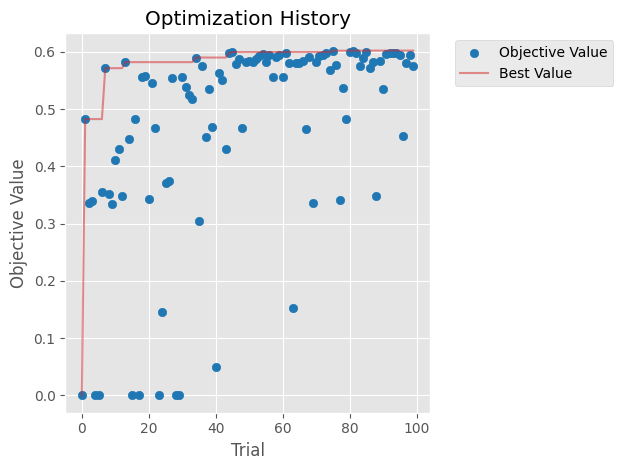

/tmp/ipykernel_11945/3310349916.py:17: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = optuna.visualization.matplotlib.plot_param_importances(study)


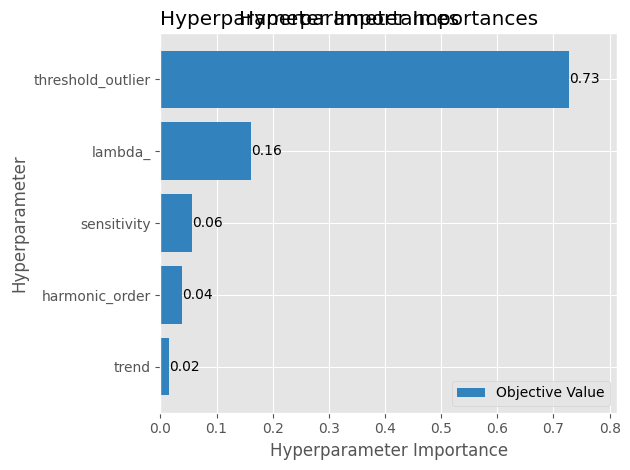

/tmp/ipykernel_11945/3310349916.py:23: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = optuna.visualization.matplotlib.plot_parallel_coordinate(study)


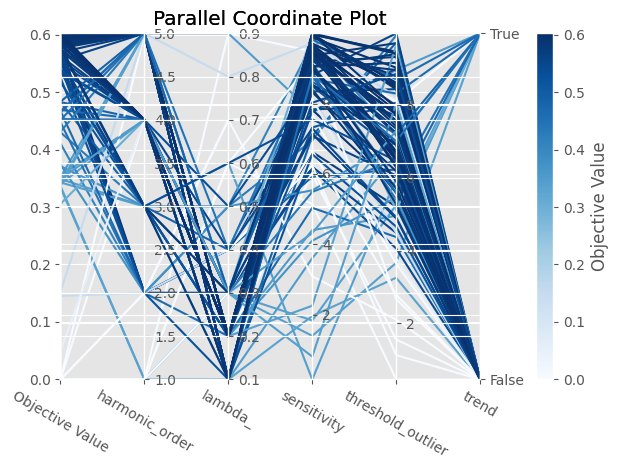

In [27]:
visualize_optimization(study_ewma)

In [28]:
study_ewma.best_params

{'trend': False,
 'harmonic_order': 4,
 'sensitivity': 9.664541382107057,
 'lambda_': 0.2,
 'threshold_outlier': 6.537230307668566}

In [23]:
def iqr_objective(trial: optuna.Trial) -> float:
    """
    Objective function for Optuna hyperparameter optimization.
    
    Args:
        trial: Optuna trial object
        
    Returns:
        Objective value to minimize (e.g., false positive rate, detection delay)
    """
    sensitivity_upper = trial.suggest_float('sensitivity_upper', 0, 10.0)
    sensitivity_lower = trial.suggest_float('sensitivity_lower', 0, 10.0)
    
    # Define hyperparameter search spaces
    params = {
        'trend': trial.suggest_categorical('trend', [True, False]),
        'harmonic_order': trial.suggest_int('harmonic_order', 1, 5),
        'sensitivity': (sensitivity_upper, sensitivity_lower),
        'boundary': trial.suggest_int('boundary', 1, 10),
        'L': trial.suggest_float('L', 3, 30.0),
    }
    
    # Initialize EWMA with suggested parameters
    nrt_class = IQR(
        trend=params['trend'],
        harmonic_order=params['harmonic_order'],
        mask=mask,
        sensitivity=params['sensitivity'],
        boundary=params['boundary']
    )
    nrt_class.fit(method="OLS", dataarray=history, screen_outliers='Shewhart', L=params['L'])
    # Monitor new observations
    for array, _date in zip(monitor.values, monitor.time.values.astype('datetime64[s]').tolist()):
        nrt_class.monitor(array=array, date=_date)

    pred = pl.DataFrame(
        {
            "sample_id": ds.sample_id.values.flatten(),
            "detection_date": nrt_class.detection_date.flatten(),
        }
    ).filter(
        pl.col.sample_id!=-1
    ).with_columns(
        pred_disturbed=pl.col.detection_date!=0
    )

    results = pred.join(
        selected_samples.unique("sample_id"),
        on="sample_id"
    )

    score = f1_score(results["true_disturbed"], results["pred_disturbed"])
    return score

In [16]:
# Create study
study = optuna.create_study(
    direction="maximize",
    study_name="F1-IQR",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study.optimize(iqr_objective, n_trials=100, show_progress_bar=True)

Best trial: 93. Best value: 0.799421: 100%|██████████| 100/100 [08:31<00:00,  5.11s/it]


In [24]:
# Create study
study_ndmi = optuna.create_study(
    direction="maximize",
    study_name="F1-IQR",
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Run optimization
study_ndmi.optimize(iqr_objective, n_trials=100, show_progress_bar=True)

Best trial: 75. Best value: 0.766906: 100%|██████████| 100/100 [08:48<00:00,  5.28s/it]


/tmp/ipykernel_125857/3310349916.py:11: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = optuna.visualization.matplotlib.plot_optimization_history(study)


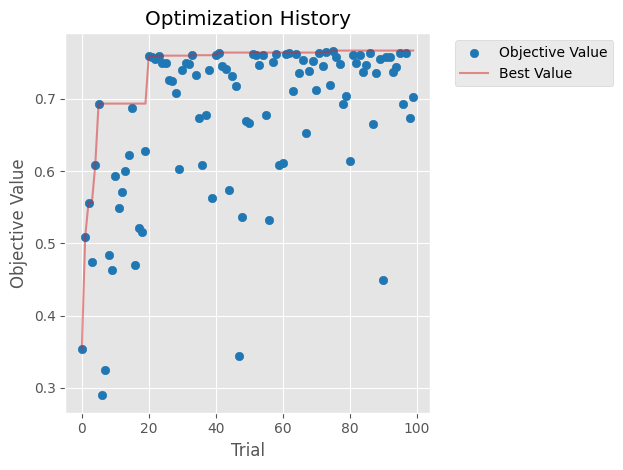

/tmp/ipykernel_125857/3310349916.py:17: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = optuna.visualization.matplotlib.plot_param_importances(study)


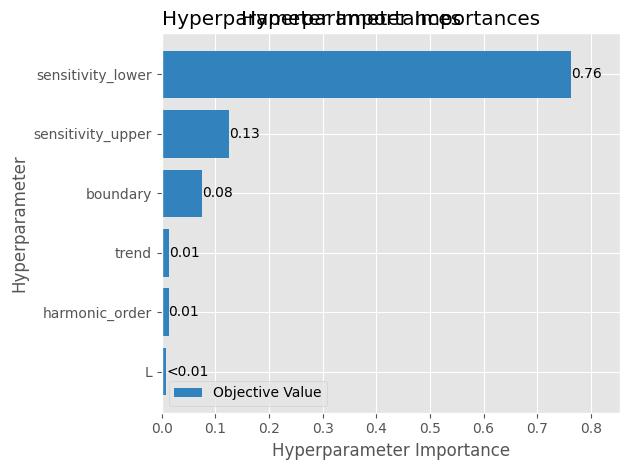

/tmp/ipykernel_125857/3310349916.py:23: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = optuna.visualization.matplotlib.plot_parallel_coordinate(study)


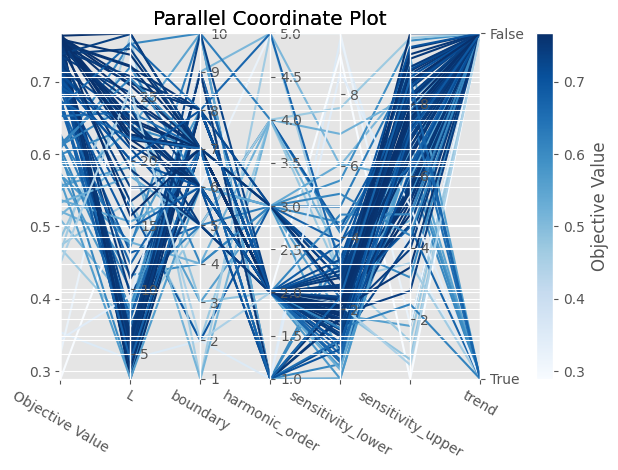

In [25]:
visualize_optimization(study_ndmi)

In [20]:
study.best_params

{'sensitivity_upper': 8.863739342930032,
 'sensitivity_lower': 1.947132456851802,
 'trend': False,
 'harmonic_order': 1,
 'boundary': 6,
 'L': 5.822364321398805}

In [57]:
study.best_params

{'trend': False,
 'harmonic_order': 2,
 'sensitivity': 1.749100093768187,
 'boundary': 8,
 'L': 4.738243945688669}

In [26]:
study_ndmi.best_params

{'sensitivity_upper': 8.16992462547153,
 'sensitivity_lower': 2.1504342678501813,
 'trend': False,
 'harmonic_order': 2,
 'boundary': 6,
 'L': 21.667165633906336}